In [1]:
from src import *
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt
import pickle

In [2]:
# Algorithm Parameters
num_qubits = 10
kd_ratio = 2.5
noise_threshold = 0
epsilon = 1e-3
delta_t = 0.083
num_modmd_observables = 6
num_trials = 5

# Analysis Parameters
r = 500
num_predicted_steps = 100
observable_index = 3

In [3]:
# Load Hamiltonian, get true eigenergies
with open('Data/Hamiltonians/LiH_equilibrium_hamiltonian.pkl', 'rb') as f:
    sparse_lih_hamiltonian = pickle.load(f)

In [4]:
# Construct reference state
reference_state = bitstring_superposition_state(num_qubits, ['0000100001', '0000000011', '0001000001','0010100000'])

# Get evolved reference states
K = int(np.round((r+num_predicted_steps+1)/(1+1/kd_ratio)))
d = int((K)/kd_ratio)
time_evolution_operator = -1j*sparse_lih_hamiltonian*delta_t
evolved_reference_states = spsl.expm_multiply(time_evolution_operator,reference_state,start=0,stop=d+K+1,num = d+K+2)

In [5]:
# Get MODMD observables
with open('Data/Hamiltonians/LiH_pauli_representation.pkl', 'rb') as f:
    lih_pauli_coefficients, lih_pauli_strings = pickle.load(f)

sorted_pauli_observables = np.array(lih_pauli_strings)[np.argsort(np.abs(lih_pauli_coefficients))[::-1]]
modmd_observables = [SparsePauliOp(p).to_matrix(sparse=True) for p in sorted_pauli_observables[75:81]]

In [6]:
X_elements = generate_X_elements(modmd_observables,d,K,reference_state,evolved_reference_states)

measured_signals = []
predicted_signals = []

for trial in range(num_trials):
    print(f'Trial {trial+1}')

    # Ground truth
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise
    measured_signals.append(noisy_X_elements[[observable_index + (i*len(modmd_observables)) for i in range(K+d+1)]])

    # Measure to some K*, extrapolate the rest
    K_star = int(np.round(r/(1+1/kd_ratio)))
    d_star = int(K_star/kd_ratio)
    X,Xp = X_matrices(len(modmd_observables),d_star,K_star,noisy_X_elements)
    A = A_matrix(noise_threshold,X,Xp,False)

    pred = []
    for predicted_step in range(num_predicted_steps):
        Xp = A@Xp
        pred.append(Xp[observable_index - num_modmd_observables,-1])

    predicted_signals.append(pred)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [7]:
# Results processing
average_measured_signal = np.average(measured_signals,0)[K_star+d_star+1:K_star+d_star+1+num_predicted_steps]
std_measured_signal = np.std(measured_signals,0)[K_star+d_star+1:K_star+d_star+1+num_predicted_steps]

average_predicted_signal = np.average(predicted_signals,0)
std_predicted_signal = np.std(predicted_signals,0)

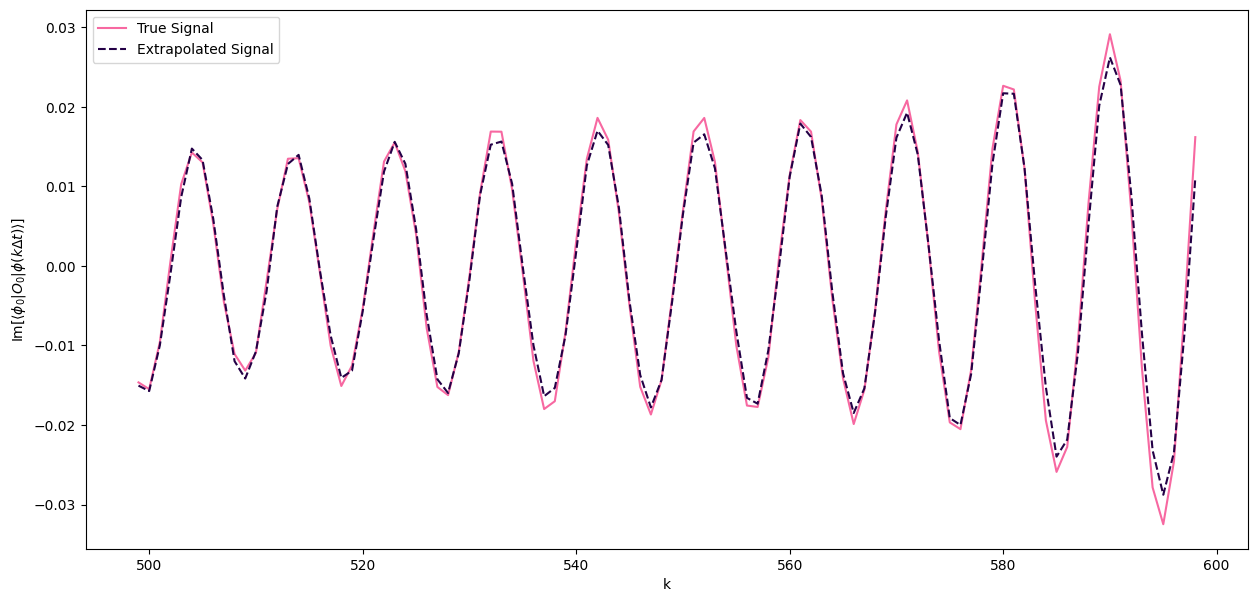

In [8]:
colors = ['#fcc5c0','#f768a1','#7a0177', '#240046']
amplitude_type = 'Im'
k_range = range(K_star+d_star,K_star+d_star+num_predicted_steps)

plt.figure(figsize=(15,7))

if amplitude_type == 'Re':
    plt.plot(k_range,average_measured_signal.real, label = 'True Signal', color = colors[1])
    plt.plot(k_range, average_predicted_signal.real, '--', label = 'Extrapolated Signal', color = colors[-1])
elif amplitude_type == 'Im':
    plt.plot(k_range,average_measured_signal.imag, label = 'True Signal', color = colors[1])
    plt.plot(k_range, average_predicted_signal.imag, '--', label = 'Extrapolated Signal', color = colors[-1])

plt.xlabel('k')
plt.ylabel(rf'{amplitude_type}[$\langle\phi_0|O_0|\phi(k\Delta t)\rangle$]')
plt.legend()

Text(0, 0.5, 'Absolute Signal Error')

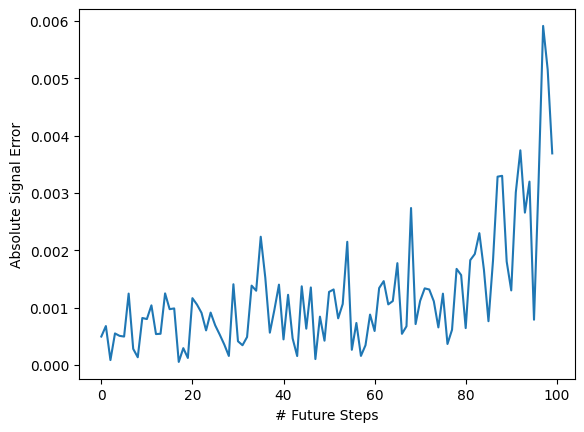

In [9]:
amplitude_type = 'Re'
if amplitude_type == 'Re':
    plt.plot(range(num_predicted_steps),np.abs(average_measured_signal.real-average_predicted_signal.real), label = 'True Signal')
elif amplitude_type == 'Im':
    plt.plot(range(num_predicted_steps),np.abs(average_measured_signal.imag-average_predicted_signal.imag), label = 'True Signal')
plt.xlabel('# Future Steps')
plt.ylabel('Absolute Signal Error')